In [1]:
import theano
from theano import tensor as T
from theano import function, config, shared, sandbox

import numpy as np
import random
import scipy
from scipy import spatial as sp
from matplotlib import pyplot as plt
%matplotlib inline  

import time

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [20]:
print(theano.config.device)
print(theano.config.floatX)

gpu
float32


In [22]:
import numpy as np
import time
import theano
A = np.random.rand(1000,10000).astype(theano.config.floatX)
B = np.random.rand(10000,1000).astype(theano.config.floatX)
np_start = time.time()
AB = A.dot(B)
np_end = time.time()
X,Y = theano.tensor.matrices('XY')
mf = theano.function([X,Y],X.dot(Y))
t_start = time.time()
tAB = mf(A,B)
t_end = time.time()
print ("NP time: %f[s], theano time: %f[s] **(times should be close when run on CPU!)**" %(np_end-np_start, t_end-t_start))
print ("Result difference: %f" % (np.abs(AB-tAB).max(), ))

NP time: 0.190495[s], theano time: 0.071920[s] **(times should be close when run on CPU!)**
Result difference: 0.021240


**Launch notebook with command: **
- THEANO_FLAGS=floatX=float32,device=gpu,allow_gc=False,nvcc.flags=-D_FORCE_INLINES,nvcc.fastmath=True jupyter notebook

In [2]:
def kmeans_theano(data, n_clusters, learning_rate = 0.0001, max_iter = 100, batch_size = 1, epsilon = 0.1, verbose = False):   
    config.floatX = 'float32'
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.dmatrix('Z') #represents the data, size n_points x n_dim
    W = T.dmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim), name="centroids")
    centroids_old = centroids.get_value()
    
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN")
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, mode="FAST_RUN")
       
    # == Kmeans with the real data ==========
    for n_iter in range(max_iter):
                    
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])
            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point belongs to 
                                                             # the cluster j
            
            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
            
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
            
    return centroids.get_value()

In [3]:
def kmeans_theano_gpu(data, n_clusters, learning_rate = 0.0001, max_iter = 100, batch_size = 1, epsilon = 0.1, verbose = False):   
    
    #for gpu optimsation use float 32
    config.floatX = 'float32'

    #print(type(learning_rate))
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    print(type(Z))
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX), name="centroids")
    #centroids_old  = centroids.get_value()
    
    
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    #update = theano.shared(update,name='update') #.astype(theano.config.floatX)
    print('def func')
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, allow_input_downcast=True,mode="FAST_RUN")
    print('starting to compute')
    if any([x.op.__class__.__name__ in ['Gemv', 'CGemv', 'Gemm', 'CGemm'] for x in update_clusters.maker.fgraph.toposort()]):
        print 'Used the cpu'
    elif any([x.op.__class__.__name__ in ['GpuGemm', 'GpuGemv'] for x in update_clusters.maker.fgraph.toposort()]):
        print 'Used the gpu'
    else:
        print 'ERROR, not able to tell if theano used the cpu or the gpu'
        print update_clusters.maker.fgraph.toposort()
    # == Kmeans with the real data ==========
    for n_iter in range(max_iter):
                    
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])
            #clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot = np.zeros([batch_size,n_clusters], config.floatX)
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point belongs to 
                                                             # the cluster j
            
            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
            
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
    

    return centroids.get_value()

In [4]:
def kmeans_theano_gpu(data, n_clusters, learning_rate = 0.0001, max_iter = 100, batch_size = 1, epsilon = 0.1, verbose = False):   
    
    #for gpu optimsation use float 32
    config.floatX = 'float32'

    #print(type(learning_rate))
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    print(type(Z))
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX), name="centroids")
    #centroids_old  = centroids.get_value()
    
    
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, allow_input_downcast=True,mode="FAST_RUN")
    
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the cpu')
    else:
        print('Used the gpu')
        
    # == Kmeans compute  ==========
    for n_iter in range(max_iter):
                    
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])
            #clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot = np.zeros([batch_size,n_clusters], config.floatX)
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point belongs to 
                                                             # the cluster j
            
            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
            
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
    

    return centroids.get_value()    

In [5]:
import theano.sandbox.cuda.basic_ops

def kmeans_theano_gpu_acc(data, n_clusters, learning_rate = 0.0001, max_iter = 100, batch_size = 1, epsilon = 0.1, verbose = False):   
    
    #for gpu optimsation use float 32
    config.floatX = 'float32'

    #print(type(learning_rate))
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    print(type(Z))
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX), name="centroids")
    #centroids_old  = centroids.get_value()
    
    
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], sandbox.cuda.basic_ops.gpu_from_host(clusters), mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, allow_input_downcast=True,mode="FAST_RUN")
    
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the cpu')
    else:
        print('Used the gpu')
        
    # == Kmeans compute  ==========
    for n_iter in range(max_iter):
                    
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])
            #clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot = np.zeros([batch_size,n_clusters], config.floatX)
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point belongs to 
                                                             # the cluster j
            
            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
            
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
    

    return centroids.get_value()    


In [6]:
from sklearn import datasets

# Test Codes
blobs = datasets.make_blobs(n_samples=4000, random_state=8)
DATA =blobs[0]

In [7]:
start_time = time.time()
W = kmeans_theano(DATA ,3,learning_rate = 0.001, max_iter=50, batch_size=100, verbose=True, epsilon = 0.1)
end_time = time.time()

Iteration 0 with a cost function at 7471.017
Iteration 10 with a cost function at 662.127
Iteration 20 with a cost function at 662.127
Iteration 30 with a cost function at 662.127
Iteration 40 with a cost function at 662.127


In [11]:
start_time = time.time()
W = kmeans_theano_gpu(DATA ,3,learning_rate = 0.001, max_iter=50, batch_size=100, verbose=True, epsilon = 0.1)
end_time = time.time()

<class 'theano.tensor.var.TensorVariable'>
Used the gpu
Iteration 0 with a cost function at 6384.498
Iteration 10 with a cost function at 600.489
Iteration 20 with a cost function at 125.960
Iteration 30 with a cost function at 125.961
Iteration 40 with a cost function at 125.961


In [9]:
start_time = time.time()
W = kmeans_theano_gpu_acc(DATA ,3,learning_rate = 0.001, max_iter=50, batch_size=100, verbose=True, epsilon = 0.1)
end_time = time.time()

<class 'theano.tensor.var.TensorVariable'>


TypeError: CudaNdarrayType only supports dtype float32 for now. Tried using dtype int64 for variable None

Kmeans with Theano : 0.683 s.


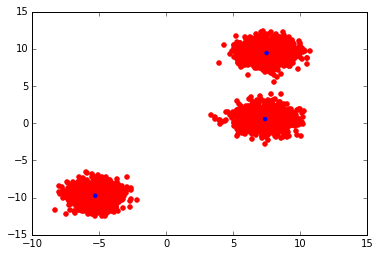

In [12]:
print("Kmeans with Theano : %.3f s." %(end_time - start_time))

plt.scatter(DATA[:,0], DATA[:,1], color='red')
plt.scatter(W[:,0],W[:,1],color='blue',s=20,edgecolor='none')

In [13]:
def getClusters_id(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

Kmeans with Theano : 0.683 s.


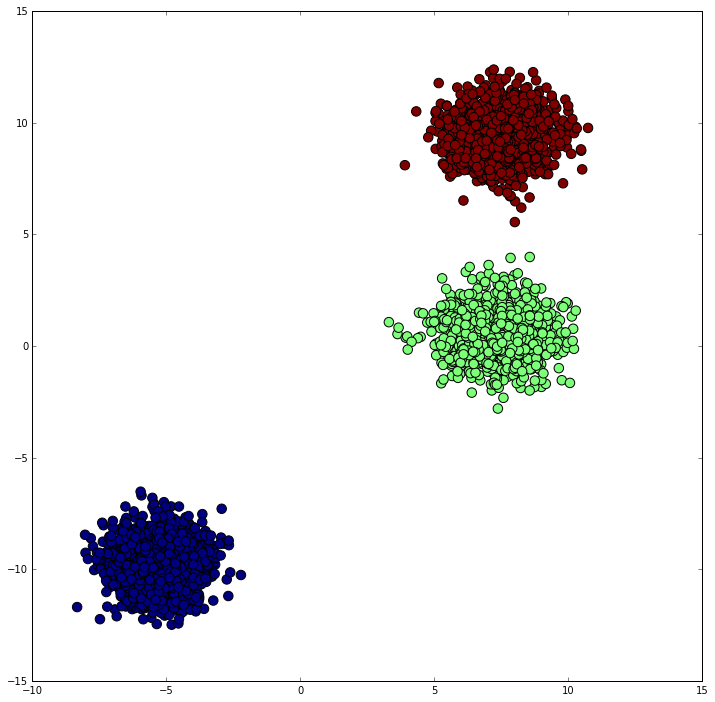

In [14]:
print("Kmeans with Theano : %.3f s." %(end_time-start_time))
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(DATA[:,0], DATA[:,1],c=getClusters_id(DATA,W,3),s=90)

## Test on pictures

Sample size : [2073600, 3]


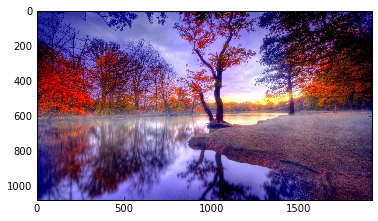

In [15]:
image = scipy.misc.imread('../data/images/beautiful-01.jpg')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
samples = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])
print('Sample size : %s' %(list(np.shape(samples))) )

In [16]:
%%time
centroids = kmeans_theano(samples,6,learning_rate = 0.0001, max_iter=100, batch_size=1080, verbose=False,
                          epsilon = 0.01)
#alpha must be really small for good results alpha = 0.0001

CPU times: user 44.7 s, sys: 0 ns, total: 44.7 s
Wall time: 44.7 s


In [17]:
%%time
centroids = kmeans_theano_gpu(samples,6,learning_rate = 0.0001, max_iter=100, batch_size=1080, verbose=False,
                          epsilon = 0.01)
#alpha must be really small for good results alpha = 0.0001

<class 'theano.tensor.var.TensorVariable'>
Used the gpu
CPU times: user 1min 35s, sys: 15.2 s, total: 1min 50s
Wall time: 1min 50s


In [18]:
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    dist_mat=cydist(dataSet,centroids)
    #dist_mat=sp.distance.cdist(dataSet,centroids,metric="euclidean")
    min_idx=dist_mat.argmin(axis=1) #vector of minimum index for each row
    mat=centroids[min_idx]
    return mat

def cydist(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    out = np.zeros((rows,cols)) 
    for dim in range(dims):
        out += np.subtract.outer(a[:,dim], b[:,dim])**2
    return out

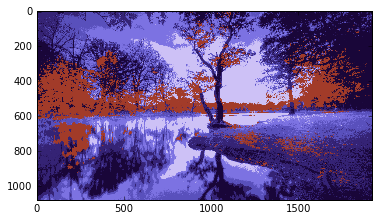

In [19]:
segmented=getLabels(samples,centroids).astype(np.uint8)
reconstruct = np.array(segmented).reshape((w,h, 3))
plt.imshow(reconstruct)